# Importing Dependencies

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime,timedelta
import numpy as np
from scipy.optimize import minimize

# Defining list of Tickers and Time range ( start and end date)

In [3]:
tickers = ['SPY' , 'BND', 'GLD', 'QQQ' , 'VTI']

In [4]:
end_date = datetime.today()

In [7]:
start_date = end_date - timedelta(days = 5 * 365)
print(start_date)

2019-07-03 23:26:58.847329


# Adjusted close prices

In [8]:
adj_close_df = pd.DataFrame()

In [9]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-07-05  275.856049  72.756516  132.139999  185.069992  140.863770
2019-07-08  274.340302  72.747749  131.289993  183.771927  140.106598
2019-07-09  274.682220  72.651062  131.750000  184.692200  140.355881
2019-07-10  275.994659  72.712601  133.830002  186.532715  140.928360
2019-07-11  276.641663  72.475296  132.699997  186.397110  141.122299
...                ...        ...         ...         ...         ...
2024-06-25  544.830017  72.599998  214.559998  479.380005  267.790253
2024-06-26  545.510010  72.260002  212.580002  480.369995  267.780304
2024-06-27  546.369995  72.389999  214.990005  481.609985  268.428009
2024-06-28  544.219971  72.050003  215.009995  479.109985  267.510010
2024-07-01  545.340027  71.449997  215.570007  481.920013  268.049988

[1256 rows x 5 columns]


# Log normal Returns

In [12]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [13]:
log_returns = log_returns.dropna()

# Covariance Matrix 

In [17]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044047  0.002955  0.003964  0.049625  0.045102
BND  0.002955  0.004835  0.003879  0.003584  0.003148
GLD  0.003964  0.003879  0.023335  0.005334  0.004185
QQQ  0.049625  0.003584  0.005334  0.064439  0.050762
VTI  0.045102  0.003148  0.004185  0.050762  0.046557


In [25]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [27]:
risk_free_rate = .02
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [28]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.2000
BND: 0.0000
GLD: 0.4000
QQQ: 0.4000
VTI: 0.0000
Expected Annual Return: 0.1435
Expected Volatility: 0.1615
Sharpe Ratio: 0.7649


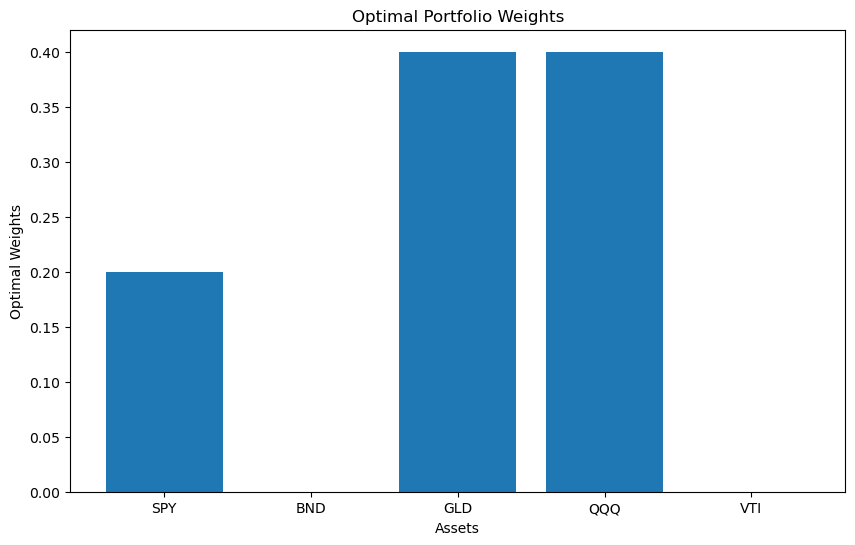

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()